In [50]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import json
import random
from pyvis.network import Network
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

True

In [51]:
def initialize_df() -> pd.DataFrame:
    df = pd.read_csv('./data/faculty_data_final.csv', encoding='ISO-8859-1')

    df = df.rename(
            columns={
                'Name': 'name',
                'School': "school",
                'Degree Program': "degree_program",
                'UGA Affiliations (e.g. Centers or Institutes etc.)': "uga_affiliations",
                'Previous Instutution(s)': "previous_institutions",
                'PhD. Degree': "phd_degree",
                'Interdisciplinary Areas': "interdisciplinary_areas",
                'Broad Speacialty Areas / Expertise': "broad_specialties",
                'Overlapping Expertise': "overlapping_expertise",
                'Research Keywords': "research_keywords",
                'Major Tool / Equipment': "equipment",
                'Potential Sponsors': "potential_sponsors",
                'UGA Collaborator(s)': "uga_collaborators",
                'Outside Collaborator(s)': "outside_collaborators",
                'Global Engagement': "global_engagement",
                'Memberships': "memberships",
                'Other Information': "other"
            }
        )

    df['name'] = df['name'].ffill()
    df['name'] = df['name'].str.strip()
    df = df.groupby('name').agg(lambda x: ', '.join(x.dropna().astype(str)))

    def combine_entries(series):
        if series.dtype == 'object':
            return ', '.join(set(', '.join(series.dropna()).split(', ')))
        else:
            return series.dropna().iloc[0]

    df = df.groupby('name').agg(combine_entries).reset_index()

    return df


In [52]:
df = initialize_df()

In [ ]:

def create_columns(df) -> pd.DataFrame:
    gen_df = df[["name", "interdisciplinary_areas", "broad_specialties", "outside_collaborators"]]
    json_data = gen_df.to_json(orient="records", indent=4)

    API_KEY = os.getenv("API_KEY")

    client = OpenAI(
        api_key=API_KEY
    )

    prompt = f"""
        You are categorizing engineering professors at the University of Georgia based on their interdisciplinary research areas and broad specialties.

        ## **Task Requirements**
        1. **You must group all professors into exactly 4-5 broad categories.**  
           - Example categories:  
               - "AI, Data Science, and Cyber-Physical Systems"  
               - "Biomedical and Health Engineering"  
               - "Energy, Environment, and Sustainability"  
               - "Materials, Manufacturing, and Robotics"  
               - "Education, Policy, and Social Impact in Engineering"  
           - **Categories must remain broad and standardized** while maintaining meaningful research connections.  
           - You may **slightly adjust** the names but **must not exceed 5 groups**.  

        2. **Strict Assignment Rules:**  
           - **Every professor must be assigned to one and only one category.**  
           - If a professor's research spans multiple areas, **assign them to the closest matching category.**  
           - If a professor's research data is completely empty, assign them `""` (empty string).  

        3. **Category Balance Enforcement:**  
           - If a category has **only one professor**, merge it with the most related category.  
           - If a category has an excessive number of professors, **split only if absolutely necessary** (and still ensure a max of 5 groups).  
           - The **final output must always contain 4-5 categories**, no more, no less.  

        4. **STRICT JSON Output Format:**  
           Your response **MUST BE STRICTLY JSON** and match the format below:  
        ```json
        {{
            "insight": "Some professors had highly interdisciplinary research, requiring careful classification.",
            "generated_disciplines": [
                {{
                    "name": "Professor A",
                    "discipline": "AI, Data Science, and Cyber-Physical Systems"
                }},
                {{
                    "name": "Professor B",
                    "discipline": "Biomedical and Health Engineering"
                }},
                {{
                    "name": "Professor C",
                    "discipline": "Materials, Manufacturing, and Robotics"
                }},
                ...
            ]
        }}
        ```

        **Deviating from this format will be considered incorrect output.**  

        ## **Input JSON Data**
        ```json
        {json_data}
        ```
    """

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        store=True,
        messages=[{
            "role": "user", 
            "content": prompt
        }]
    )

    raw_content = completion.choices[0].message.content.strip()

    if raw_content.startswith("```json"):
        raw_content = raw_content[7:-3]

    data = json.loads(raw_content)
    disciplines_df = pd.DataFrame(data["generated_disciplines"])
    disciplines_df.set_index("name", inplace=True)
    disciplines_df.index = disciplines_df.index.str.strip()
    
    df_json = df.to_json(orient="records", indent=4)
    second_prompt = f"""
        You are tasked with categorizing engineering professors at the University of Georgia based on their **relatedness to other professors**. Your goal is to **group professors into strictly defined clusters** based on shared collaborators, research areas, disciplines, and institutional affiliations.

        ## **Instructions**
        1. **You must calculate connection strength using only the following columns:**
            - **'uga_collaborators'** (Shared UGA collaborators)
            - **'outside_collaborators'** (Shared external collaborators)
            - **'interdisciplinary_areas'** (Shared interdisciplinary areas)
            - **'broad_specialties'** (Shared broad specialties)
            - **'generated_disciplines'** (Identical generated discipline)
            - **'overlapping_expertise'** (Number of overlapping expertise)
            - **'current_affiliation'** (Same or highly related affiliation)
            - **'school'** (Same or highly related school)

        2. **Connection weights MUST be assigned using the following STRICT formula:**
            - **Overlapping Expertise (Weight: 3 per shared expertise)** → Example: If two professors share 2 overlapping expertise areas, weight = **6.0**.
            - **Shared UGA Collaborators (Weight: 2 per collaborator)** → Example: If two professors share 3 UGA collaborators, weight = **6.0**.
            - **Shared Outside Collaborators (Weight: 1.5 per collaborator)** → Example: If two professors share 3 outside collaborators, weight = **4.5**.
            - **Shared Interdisciplinary Areas (Weight: 1 per area)** → Example: If two professors share 2 interdisciplinary areas, weight = **2.0**.
            - **Shared Broad Specialties (Weight: 1 per specialty)** → Example: If two professors share 3 broad specialties, weight = **3.0**.
            - **Same Generated Discipline (Weight: 2 if True, 0 if False)**.
            - **Same Current Affiliation / Degree Program (Weight: 0.5 if True, 0 if False)**.
            - **Same School (Weight: 0.3 if True, 0 if False)**.
            - **TOTAL connection strength is the sum of all applicable weights. The final value MUST be rounded to one decimal place.**

        3. **Ensure consistency in reasoning by explicitly listing column contributions for each connection.**  
        **Do NOT generate random relationships**—only professors with nonzero connection weight should be included in the output.

        ## **Example of the Required JSON Output Format**
        Your response **MUST ONLY** be a JSON object in this format:
        ```json
        {{
            "insight": "Some professors had no strong connections due to lack of collaborators or overlapping expertise.",
            "generated_groups": [
                {{
                    "name": "Professor A",
                    "related_professors": [
                        {{
                            "name": "Professor B",
                            "weight": 6.5,
                            "reasoning": {{
                                "uga_collaborators": 2,
                                "outside_collaborators": 1,
                                "interdisciplinary_areas": 1,
                                "broad_specialties": 0,
                                "generated_disciplines": true,
                                "overlapping_expertise": 0,
                                "current_affiliation": false,
                                "school": false
                            }}
                        }},
                        {{
                            "name": "Professor C",
                            "weight": 3.0,
                            "reasoning": {{
                                "uga_collaborators": 0,
                                "outside_collaborators": 0,
                                "interdisciplinary_areas": 0,
                                "broad_specialties": 0,
                                "generated_disciplines": true,
                                "overlapping_expertise": 0,
                                "current_affiliation": false,
                                "school": false
                            }}
                        }}
                    ]
                }},
                ...
            ]
        }}
        ```
        **Failure to follow this format exactly will result in incorrect output. Do not deviate from these instructions.**

        ## **Input Data**
        ```json
        {df_json}
        ```
    """

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        store=True,
        messages=[{
            "role": "user", 
            "content": second_prompt
        }]
    )
    raw_content = completion.choices[0].message.content.strip()

    if raw_content.startswith("```json"):
        raw_content = raw_content[7:-3]

    relatedness_data = json.loads(raw_content)

    relatedness_df = pd.DataFrame(relatedness_data["generated_groups"])
    print(relatedness_df)
    relatedness_df = relatedness_df.reset_index(drop=True).set_index('name')

    # Convert to tuples
    relatedness_df["related_professors"] = relatedness_df["related_professors"].apply(
        lambda x: [(rel["name"], float(rel["weight"])) for rel in x]
    )

    relatedness_df.index = relatedness_df.index.str.strip()

    df = df.reset_index(drop=True).set_index('name')
    df = df.merge(disciplines_df, left_index=True, right_index=True, how="left")
    df = df.merge(relatedness_df, left_index=True, right_index=True, how="left")

    df_exploded = df.copy()

    df_exploded = df_exploded.assign(overlapping_expertise=df_exploded['overlapping_expertise'].str.split(',')).explode('overlapping_expertise')
    df_exploded = df_exploded.assign(uga_collaborators=df_exploded['uga_collaborators'].str.split(',')).explode('uga_collaborators')
    df_exploded = df_exploded.assign(potential_sponsors=df_exploded['potential_sponsors'].str.split(',')).explode('potential_sponsors')

    df_exploded['overlapping_expertise'] = df_exploded['overlapping_expertise'].str.strip()
    df_exploded['uga_collaborators'] = df_exploded['uga_collaborators'].str.strip()
    df_exploded['potential_sponsors'] = df_exploded['potential_sponsors'].str.strip()

    return df_exploded

In [54]:
df = create_columns(df)

                     name                                 related_professors
0               Beiwen Li  [{'name': 'Hongyue Sun', 'weight': 13.5, 'reas...
1             Hongyue Sun  [{'name': 'Diego Chen', 'weight': 9.3, 'reason...
2  Felix Santiago Collazo  [{'name': 'Whitney Lisenbee', 'weight': 9.0, '...
3             Haijian Sun  [{'name': 'Qianwen Li', 'weight': 11.0, 'reaso...


In [58]:

def plot_graph(df, 
               search_professor=False, 
               category_search_parameter="degree_program", 
               professor_search_parameter=None,
               min_weight=0
    ):
    if not search_professor:
        graphs = {}
        miscellaneous = []  # will hold nodes from groups with only one element

        # Loop over each unique group value
        for value in df[category_search_parameter].unique():
            if pd.isna(value) or value == "":
                continue

            subset = df[df[category_search_parameter] == value]

            # If this category only has one node, add it to miscellaneous and skip plotting it
            if len(subset) == 1:
                miscellaneous.extend(list(subset.index))
                continue

            # Build a global graph based on shared expertise
            G = nx.Graph()
            all_nodes = df.index.unique()  # assuming the index identifies a person
            G.add_nodes_from(all_nodes)

            # Iterate over each unique expertise in the exploded column
            for expertise in df[category_search_parameter].unique():
                if pd.isna(expertise) or expertise == "":
                    continue

                # Get the unique nodes that have this expertise
                nodes = list(df[df[category_search_parameter] == expertise].index.unique())

                # For every pair of nodes sharing the expertise, add or update an edge
                for i in range(len(nodes)):
                    for j in range(i + 1, len(nodes)):
                        if G.has_edge(nodes[i], nodes[j]):
                            G[nodes[i]][nodes[j]]['weight'] += 2
                        else:
                            G.add_edge(nodes[i], nodes[j], weight=2)

            graphs = {"Expertise Graph": G}

        # Visualize the graphs for groups with more than one node
        num_graphs = len(graphs)
        cols = 2
        rows = (num_graphs + cols - 1) // cols

        plt.figure(figsize=(cols * 5, rows * 4))

        for i, (value, G) in enumerate(graphs.items(), 1):
            plt.subplot(rows, cols, i)            
            pos = nx.spring_layout(G, k=0.2, seed=42)
            
            nx.draw(
                G, pos, with_labels=True, node_color='lightblue', node_size=1500,
                font_size=10, font_weight='normal', edge_color='gray', width=2,
                alpha=0.7, edgecolors="black"
            )
            plt.title(value, fontsize=12)

        # Optionally, output the miscellaneous nodes (not plotted)
        print("Miscellaneous nodes (grouped but not plotted):", miscellaneous)

        # Optionally, if you want to visualize one of the graphs in a network visualizer:
        if graphs:
            # Here we use the last graph in the dictionary
            last_key = list(graphs.keys())[-1]
            G = graphs[last_key]
            pos = nx.spring_layout(G, k=0.2, seed=42)
            node_colors = ["pink" if node == professor_search_parameter else "lightgreen" for node in G.nodes]

            nx.draw(
                G, pos, with_labels=True, node_color=node_colors, node_size=1500,
                font_size=12, font_weight='normal', edge_color='gray', width=2,
                alpha=0.7, edgecolors="black"
            )
            
            # Draw edge labels if available
            edge_labels = nx.get_edge_attributes(G, 'weight')
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

            #nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", select_menu=True, filter_menu=True)
            nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

            nt.set_options("""
            const options = {
                "nodes": {
                    "color": {
                        "background": "lightgreen",
                        "border": "white",
                        "highlight": {
                            "background": "pink",
                            "border": "pink"
                        },
                        "hover": {
                            "background": "yellow",
                            "border": "white"
                        }
                    },
                    "font": {
                        "color": "white"
                    }
                },
                "edges": {
                    "color": {
                        "color": "gray",
                        "highlight": "pink"
                    },
                    "width": 2,
                    "smooth": {
                        "type": "curvedCW",
                        "roundness": 0.2
                    }
                },
                "interaction": {
                    "hover": true,
                    "selectConnectedEdges": true
                },
                "physics": {
                    "barnesHut": {
                        "theta": 0.35,
                        "damping": 0.41,
                        "avoidOverlap": 0.8
                    },
                    "minVelocity": 0.75
                }
            }
            """)
            nt.from_nx(G)        
            nt.show(f'{category_search_parameter.replace(" ", "_")}.html', notebook=False)

            # Open the HTML file and modify its styles
            with open(f'{category_search_parameter.replace(" ", "_")}.html', 'r', encoding='utf-8') as f:
                html = f.read()

            # Remove any extra padding or margins around the graph container
            html = html.replace(
                '<body>',
                '<body style="margin: 0; padding: 0; overflow: hidden;">'
            )

            # Write the modified HTML back
            with open('graph.html', 'w', encoding='utf-8') as f:
                f.write(html)

    elif search_professor:
        professor_data = df[df.index == professor_search_parameter]

        if not professor_data.empty:
            related_professors = professor_data['related_professors'].values[0]
            
            G = nx.Graph()
            G.add_node(professor_search_parameter)
            added_nodes = {professor_search_parameter}
            visited = set([professor_search_parameter])
            
            # Perform BFS for 1st, 2nd, and further layers
            layer_queue = [(professor_search_parameter, related_professors)]  # (professor, related_professors)
            
            # For each layer, we'll expand the related professors
            while layer_queue:
                current_layer = layer_queue.pop(0)  # Get the next professor and their related professors
                current_professor, related_professors = current_layer
                
                # Add all related professors from this layer
                for related_professor, weight in related_professors:
                    if min_weight > weight:
                        continue
                    if related_professor not in added_nodes:
                        G.add_node(related_professor)
                        G.add_edge(current_professor, related_professor, weight=weight)
                        added_nodes.add(related_professor)
                        visited.add(related_professor)  # Mark as visited

                        # Add all related professors of the current professor to the queue for the next layer
                        if related_professor in df.index:
                            next_layer_professors = df.loc[related_professor, 'related_professors']

                            if isinstance(next_layer_professors, float):
                                continue

                            # Only add to the queue if this professor hasn't been visited already
                            for next_related_professor, _ in next_layer_professors:                            
                                if next_related_professor not in visited:
                                    layer_queue.append((related_professor, next_layer_professors))

            pos = nx.spring_layout(G, k=0.2, seed=42)

            node_colors = ["pink" if node == professor_search_parameter else "lightgreen" for node in G.nodes]

            nx.draw(
                G, pos, with_labels=True, node_color=node_colors, node_size=1500,
                font_size=12, font_weight='normal', edge_color='gray', width=2,
                alpha=0.7, edgecolors="black"
            )
            
            edge_labels = nx.get_edge_attributes(G, 'weight')
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        else:
            print(f"Professor '{professor_search_parameter}' not found in the dataset.")

In [59]:
df

,school,degree_program,uga_affiliations,previous_institutions,phd_degree,interdisciplinary_areas,broad_specialties,overlapping_expertise,research_keywords,equipment,potential_sponsors,uga_collaborators,outside_collaborators,global_engagement,memberships,other,discipline,related_professors
name,,,,,,,,,,,,,,,,,,
Beiwen Li,ECAM,"Optical Engineering, Mechanical Engineering",IIPA,Iowa State University,Mechanical Engineering,,Monitoring of defect in manufacturing parts fo...,Hyperspectral Imaging,"In-situ application of 3D-vision, 3D Optical S...",,"NSF - National Science Foundation, DOE EER, U....",Zhenglu Li (plant breedy),"Iowa State University, Purdue University, Univ...",China,"SPIE, ASME, Optica",,"Materials, Manufacturing, and Robotics","[(Hongyue Sun, 13.5), (Christina Fuller, 12.0)]"
Beiwen Li,ECAM,"Optical Engineering, Mechanical Engineering",IIPA,Iowa State University,Mechanical Engineering,,Monitoring of defect in manufacturing parts fo...,Hyperspectral Imaging,"In-situ application of 3D-vision, 3D Optical S...",,"NSF - National Science Foundation, DOE EER, U....",Hongyue Sun,"Iowa State University, Purdue University, Univ...",China,"SPIE, ASME, Optica",,"Materials, Manufacturing, and Robotics","[(Hongyue Sun, 13.5), (Christina Fuller, 12.0)]"
Beiwen Li,ECAM,"Optical Engineering, Mechanical Engineering",IIPA,Iowa State University,Mechanical Engineering,,Monitoring of defect in manufacturing parts fo...,Agricultural Technologies,"In-situ application of 3D-vision, 3D Optical S...",,"NSF - National Science Foundation, DOE EER, U....",Zhenglu Li (plant breedy),"Iowa State University, Purdue University, Univ...",China,"SPIE, ASME, Optica",,"Materials, Manufacturing, and Robotics","[(Hongyue Sun, 13.5), (Christina Fuller, 12.0)]"
Beiwen Li,ECAM,"Optical Engineering, Mechanical Engineering",IIPA,Iowa State University,Mechanical Engineering,,Monitoring of defect in manufacturing parts fo...,Agricultural Technologies,"In-situ application of 3D-vision, 3D Optical S...",,"NSF - National Science Foundation, DOE EER, U....",Hongyue Sun,"Iowa State University, Purdue University, Univ...",China,"SPIE, ASME, Optica",,"Materials, Manufacturing, and Robotics","[(Hongyue Sun, 13.5), (Christina Fuller, 12.0)]"
Beiwen Li,ECAM,"Optical Engineering, Mechanical Engineering",IIPA,Iowa State University,Mechanical Engineering,,Monitoring of defect in manufacturing parts fo...,Optical Imaging,"In-situ application of 3D-vision, 3D Optical S...",,"NSF - National Science Foundation, DOE EER, U....",Zhenglu Li (plant breedy),"Iowa State University, Purdue University, Univ...",China,"SPIE, ASME, Optica",,"Materials, Manufacturing, and Robotics","[(Hongyue Sun, 13.5), (Christina Fuller, 12.0)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whitney Lisenbee,ECAM,Environmental Engineering,,"University of Tennessee, Pennsylvania State Un...","Environmental Engineering, Civil Engineering",,"- Stormwater mgmt, Circular Agriculture i...",Resilience,"Hydrology, Water quality, Circular Bioeconomy,...",Water quality SONDE,"NSF, NIFA, USGS",Jenna Jambeck,"Gwinnett county Public water / Div. of Water, ...",,"ASEE, EES - Ecology Soc., ASABE",,"Energy, Environment, and Sustainability",NaN
Whitney Lisenbee,ECAM,Environmental Engineering,,"University of Tennessee, Pennsylvania State Un...","Environmental Engineering, Civil Engineering",,"- Stormwater mgmt, Circular Agriculture i...",Resilience,"Hydrology, Water quality, Circular Bioeconomy,...",Water quality SONDE,"NSF, NIFA, USGS",Wes Porter,"Gwinnett county Public water / Div. of Water, ...",,"ASEE, EES - Ecology Soc., ASABE",,"Energy, Environment, and Sustainability",NaN
Yunli Shao,ECAM,Mechanical Engineering,CSMLL,"Oak Ridge National Laboratory, University of M...",Mechanical Engineering,,"* optimization algorithms, connected vehic...",Connected Networks,"E-mobility, Optimal Control, Traffic modeling ...","CARLA, Vehicle Simulator, IPG CarMaker, Python...","DOD, MSF",,"LEIDOS, ORNL, F

Miscellaneous nodes (grouped but not plotted): ['Julie Martin']
school.html


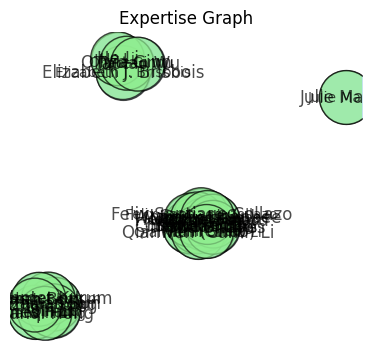

In [67]:
plot_graph(
    df, 
    search_professor=False,
    category_search_parameter="school",
    #professor_search_parameter="Christina Fuller"
)